<a href="https://colab.research.google.com/github/Gowsi-30/Final-Year-Project/blob/main/Topic_24_Sep_25__(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Postpartum Depression (PPD) Risk
# Project Overview:

**Goal.** Assess how well psychological, demographic, and questionnaire features classify mothers into **risk vs. non-risk** groups for postpartum depression (PPD), and identify the most influential predictors for early clinical support.

**Context.**
- Use EPDS (Edinburgh Postnatal Depression Scale) signals and related variables (e.g., sleep, mood, social support, demographics).
- Focus on building transparent, baseline models suitable for clinical decision support and subsequent validation.

**Objectives.**
- Assess classification performance of baseline models (Logistic Regression, Random Forest).
- Determine which questionnaire items and demographics are most predictive.
- Evaluate model utility for early intervention using clinically relevant metrics.

**Data & Preprocessing.**
- Load `records.csv`; inspect schema, types, and missingness.
- Construct or verify EPDS total if item-level responses exist.
- Split features into numeric/categorical; impute, one-hot encode, and scale where appropriate.
- Define a binary postpartum risk label (ensure correct target column).

**EDA.**
- Summaries of distributions, missingness, and correlations.
- Visualize EPDS totals (if available) and key feature distributions.

**Modeling & Evaluation.**
- Train Logistic Regression and Random Forest with a consistent preprocessing pipeline.
- Report Accuracy, Precision, Recall, F1, ROC-AUC; plot ROC curves.
- Extract feature importances (from RF) for interpretability.

**Quality, Fairness, and Next Steps.**
- Inspect class balance and potential biases across subgroups.
- Calibrate thresholds for clinical use; consider PR curves when classes are imbalanced.
- Plan external validation and robustness checks before deployment.


This notebook follows your project flow:

1. **Load & inspect data** from `records.csv`  
2. **Exploratory Data Analysis (EDA)** — structure, missingness, distributions, correlations  
3. **Preprocessing** — target detection, feature typing, imputers, encoders, scaling  
4. **Modeling** — Logistic Regression and Random Forest baselines  
5. **Evaluation** — accuracy, precision, recall, F1, ROC-AUC, ROC curves  
6. **Feature importance** — top drivers from Random Forest  
7. **Next steps** — guidance to refine for your exact schema

> Tip: If the file uses different column names, update the `TARGET_CANDIDATES` or the EPDS item name patterns in the cells below.


## Imports
Set up all libraries used in this analysis.

In [1]:

# Core
import os
import sys
import math
import numpy as np
import pandas as pd

# Plots (matplotlib only; no seaborn and no custom colors, per your requirements)
import matplotlib.pyplot as plt

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve
)

# Display options
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)


## Load Data
Read the dataset and show basic structure.

In [3]:

DATA_PATH = "/records.csv"  # Update if needed


df = pd.read_csv(DATA_PATH)
print(f"Shape: {df.shape}")
display(df.head(10))


Shape: (14325, 24)


,category,age,homeDistrict,homeCounty,homeSubCounty,homeParish,occupation,workDistrict,workCounty,workSubCounty,workParish,relationshipStatus,spouseOccupation,polygamy,otherChildren,numStillBorn,numMissCarry,education,evaluation_date,dueDate,hospital,followup_status,Total Score,Anxiety
0,0,33,Kampala,KCCA,Central Division,Old Kampala,informal business owner,Kampala,KCCA,Central Division,Old Kampala,Cohabiting,informal business owner,Yes,2,0,1,A-level,31/01/2022,28/06/2022,Mengo Kisenyi HCIV,NaN,13,5
1,0,36,Kampala,KCCA,Central Division,Kamwokya Ii,Unemployed,NaN,NaN,NaN,NaN,Traditional Marriage,formal business owner,No,1,0,1,Degree/Diploma,01/02/2022,08/03/2022,KCCA hospital,NaN,12,2
2,0,31,Kampala,KCCA,Nakawa Division,Mutungo,Unemployed,NaN,NaN,NaN,NaN,Cohabiting,informal business owner,Yes,1,1,1,O-level,01/02/2022,14/06/2022,KCCA hospital,pending,14,3
3,0,26,Kampala,KCCA,Nakawa Division,Bugolobi,informal business owner,Kampala,KCCA,Central Division,Bukesa,Formal Union,informal business owner,No,2,1,0,O-level,01/02/2022,01/02/2022,KCCA HCIII - Bugolobi,pending,13,4
4,0,14,Kampala,KCCA,Central Division,Industrial Area,formal business owner,Kampala,KCCA,Nakawa Division,Bugolobi,Formal Union,formal employee,No,1,1,1,O-level,01/02/2022,01/02/2022,KCCA HCIII - Bugolobi,pending,11,5
5,0,29,Wakiso,Kira Municipality,Namugongo Division,Kireka,Unemployed,NaN,NaN,NaN,NaN,Cohabiting,informal business owner,No,2,0,1,O-level,01/02/2022,23/02/2022,KCCA hospital,NaN,11,3
6,0,28,Kampala,KCCA,Central Division,Civic Centre,informal business owner,Kampala,KCCA,Central Division,Bukesa,Formal Union,Unemployed,No,3,1,1,O-level,01/02/2022,01/02/2022,KCCA HCIII - Bugolobi,pending,17,5
7,0,45,Kampala,KCCA,Nakawa Division,Nakawa,formal business owner,Kampala,KCCA,Nakawa Division,Nakawa,Cohabiting,formal employee,No,4,1,1,Lower Primary/ None,01/02/2022,08/04/2022,KCCA hospital,pending,14,5
8,0,30,Kampala,KCCA,Nakawa Division,Bugolobi,formal business owner,Kampala,KCCA,Nakawa Division,Bugolobi,Formal Union,formal employee,No,3,1,1,O-level,01/02/2022,01/02/2022,KCCA HCIII - Bugolobi,NaN,11,4
9,0,24,Kampala,KCCA,Nakawa Division,Luzira Prisons,formal business owner,Kampala,KCCA,Nakawa Division,Luzira Prisons,Cohabiting,informal business owner,No,2,1,0,O-level,01/02/2022,28/06/2022,KCCA hospital,pending,17,6



## Exploratory Data Analysis (EDA)
In this cell we review:
- Column names & dtypes  
- Missingness summary  
- Quick stats for numeric features  
- Candidate targets (PPD labels) if present  


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14325 entries, 0 to 14324
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   category            14325 non-null  int64 
 1   age                 14325 non-null  object
 2   homeDistrict        14325 non-null  object
 3   homeCounty          14325 non-null  object
 4   homeSubCounty       14325 non-null  object
 5   homeParish          14325 non-null  object
 6   occupation          14325 non-null  object
 7   workDistrict        5159 non-null   object
 8   workCounty          5159 non-null   object
 9   workSubCounty       11810 non-null  object
 10  workParish          5159 non-null   object
 11  relationshipStatus  14325 non-null  object
 12  spouseOccupation    14325 non-null  object
 13  polygamy            14325 non-null  object
 14  otherChildren       14325 non-null  int64 
 15  numStillBorn        14325 non-null  int64 
 16  numMissCarry        14

In [15]:
df.isnull().sum()

,0
category,0
age,0
homeDistrict,0
homeCounty,0
homeSubCounty,0
homeParish,0
occupation,0
workDistrict,0
workCounty,0
workSubCounty,0


In [5]:
df.describe(include=[np.number])

,category,otherChildren,numStillBorn,numMissCarry,Total Score,Anxiety
count,14325.0,14325.000000,14325.00000,14325.000000,14325.000000,14325.000000
mean,0.0,1.611449,0.88014,0.687609,10.050052,3.642653
std,0.0,1.351236,0.32481,0.463484,3.983745,1.611571
min,0.0,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.00000,0.000000,8.000000,3.000000
50%,0.0,2.000000,1.00000,1.000000,10.000000,3.000000
75%,0.0,3.000000,1.00000,1.000000,12.000000,5.000000
max,0.0,5.000000,1.00000,1.000000,29.000000,9.000000


# **Creating the Binary PPD Risk Label from EPDS (with references)**

**What we add.** We create a new column from the EPDS **Total Score** using a **primary cut-point of 10**:
- **`ppd_risk`** = 1 (elevated risk) if **Total Score ≥ 10**, else 0.

**Why use ≥10 as the primary cut-point?**  
Many clinical programs and research syntheses use **10+** as a **more sensitive** screening threshold to capture more potential cases, with the understanding that specificity is lower than at higher thresholds. Major reviews examine performance at **10+** and **13+**, and clinical resources commonly reference **10+** for a positive screen.

**References (add as inline links or footnotes):**
- **BMJ individual-participant-data meta-analysis** evaluating common EPDS thresholds (including **10+** and **13+**) and their accuracy:  
  https://www.bmj.com/content/371/bmj.m4022
- **MGH Center for Women’s Mental Health** — discussion of traditional thresholds and their use:  
  https://womensmentalhealth.org/posts/using-epds-measure-postpartum-depression-severity/
- **UNC EPDS handout** (clinical guidance on interpreting EPDS scores):  
  https://www.med.unc.edu/ncmatters/wp-content/uploads/sites/1000/2025/04/edinburghscale.pdf

**EPDS context.** The EPDS has **10 items** scored **0–3** each (total **0–30**). It is a **screening** tool; scores inform, but do not replace, clinical judgment. Using **10+ (primary)** emphasizes sensitivity for case-finding; you may optionally report analyses at **13+** as a higher-specificity comparison.


In [6]:



EPDS_PRIMARY_THRESHOLD = 10  # primary cut-point (probable depression)

# Ensure numeric
df["Total Score"] = pd.to_numeric(df["Total Score"], errors="coerce")

# Primary label only
df["ppd_risk"] = (df["Total Score"] >= EPDS_PRIMARY_THRESHOLD).astype(int)

# Summary (counts and proportions)
ppd_summary = pd.DataFrame({
    "count": df["ppd_risk"].value_counts().sort_index(),
    "proportion": df["ppd_risk"].value_counts(normalize=True).sort_index().round(4)
})
ppd_summary.index = ppd_summary.index.map({0: "low_risk (<13)", 1: "high_risk (≥13)"})
print("PPD risk label (primary threshold ≥13):")
display(ppd_summary)




PPD risk label (primary threshold ≥13):


,count,proportion
ppd_risk,,
low_risk (<13),6794,0.4743
high_risk (≥13),7531,0.5257


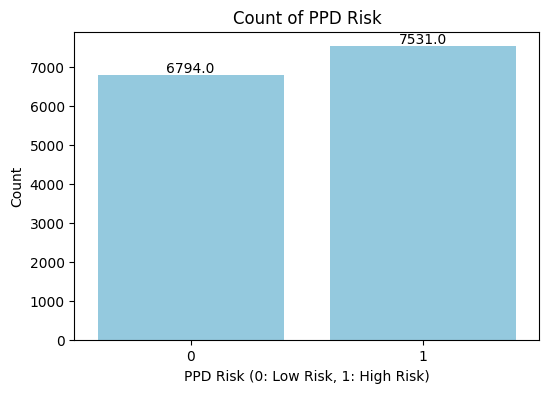

In [17]:

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
# Change color using the 'color' parameter
ax = sns.countplot(x='ppd_risk', data=df, color='skyblue')
plt.title('Count of PPD Risk')
plt.xlabel('PPD Risk (0: Low Risk, 1: High Risk)')
plt.ylabel('Count')

# Add count numbers on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

# **Handle missing values:**
 - Add missingness indicators for heavily-missing columns
 - Fill categorical NaNs with "Unknown"
 - (Numeric imputation kept for completeness, though your numerics show 0 missing)

In [18]:


# Compute missingness rates
missing_rate = df.isna().mean()

#  Choose a threshold for "heavily missing" (e.g., >=30%)
HEAVY_MISS_THRESHOLD = 0.30
heavy_missing_cols = missing_rate[missing_rate >= HEAVY_MISS_THRESHOLD].index.tolist()

# Add missingness indicator columns for heavily-missing features

for col in heavy_missing_cols:
    df[f"{col}_missing"] = df[col].isna().astype(int)

#  Identify categorical vs numeric
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

#  Impute categorical: treat NaN as an informative category "Unknown"
if cat_cols:
    df[cat_cols] = df[cat_cols].fillna("Unknown")

# Numeric imputation: median (your numerics have no NaNs, so this is a no-op)
if num_cols:
    df[num_cols] = df[num_cols].apply(lambda s: s.fillna(s.median()))

# show remaining missingness (should be 0 except impossible values)
print("Remaining missingness (top 10):")
print(df.isna().sum().sort_values(ascending=False).head(10))


Remaining missingness (top 10):
category         0
age              0
homeDistrict     0
homeCounty       0
homeSubCounty    0
homeParish       0
occupation       0
workDistrict     0
workCounty       0
workSubCounty    0
dtype: int64


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14325 entries, 0 to 14324
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   category                 14325 non-null  int64 
 1   age                      14325 non-null  object
 2   homeDistrict             14325 non-null  object
 3   homeCounty               14325 non-null  object
 4   homeSubCounty            14325 non-null  object
 5   homeParish               14325 non-null  object
 6   occupation               14325 non-null  object
 7   workDistrict             14325 non-null  object
 8   workCounty               14325 non-null  object
 9   workSubCounty            14325 non-null  object
 10  workParish               14325 non-null  object
 11  relationshipStatus       14325 non-null  object
 12  spouseOccupation         14325 non-null  object
 13  polygamy                 14325 non-null  object
 14  otherChildren            14325 non-nul

# **Exploratory Data Analysis (EDA): Structure, Missingness, Distributions, and Relationships**

**Purpose.** explores the cleaned dataset to understand its shape, feature types, missingness patterns, value distributions, and how the new label (`ppd_risk`) relates to key variables. Outputs are kept compact and visualized with matplotlib.



## **Distributions**
   - Histograms for **EPDS Total Score** (0–30) and **Anxiety** subscale to visualize skew, tails, and mode(s).

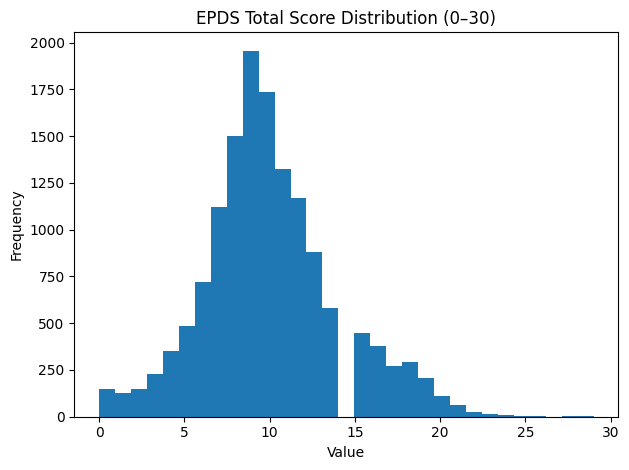

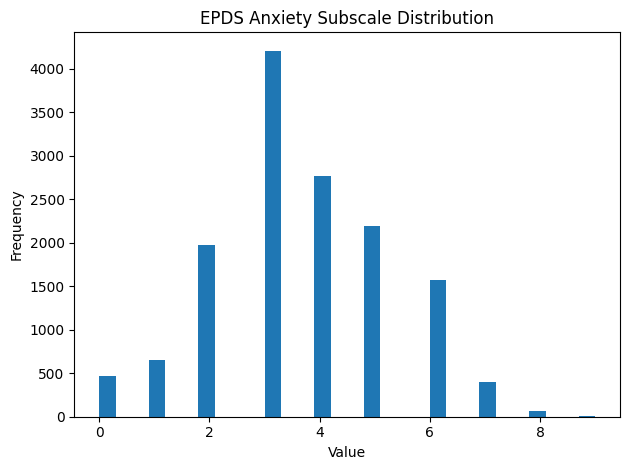

In [11]:
#  Distributions
def plot_hist(series, title, bins=30):
    plt.figure()
    plt.hist(series.dropna(), bins=bins)
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_hist(df["Total Score"], "EPDS Total Score Distribution (0–30)", bins=31)
plot_hist(df["Anxiety"], "EPDS Anxiety Subscale Distribution")

## **Correlations (numeric)**
   - Heatmap of Pearson correlations among numeric features, useful for spotting collinearity and broad signal alignment (e.g., `Total Score` vs. `Anxiety`).

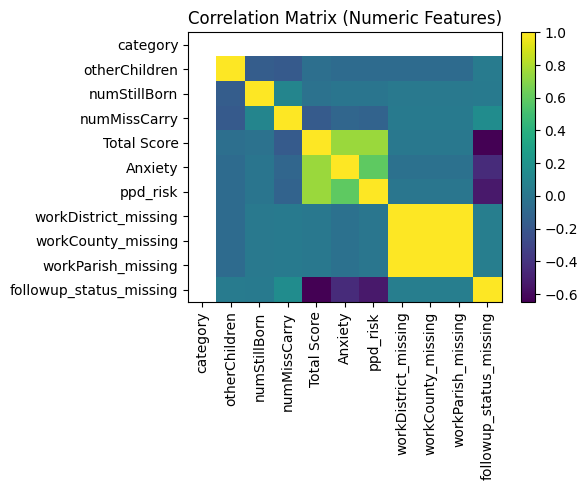

In [12]:
numeric_cols = [
    "category", "otherChildren", "numStillBorn", "numMissCarry",
    "Total Score", "Anxiety", "ppd_risk",
    "workDistrict_missing", "workCounty_missing", "workParish_missing", "followup_status_missing"
]
#  Correlations (numeric)
corr = df[numeric_cols].corr(numeric_only=True)
plt.figure(figsize=(6, 5))
plt.imshow(corr.values, aspect='auto', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation Matrix (Numeric Features)")
plt.tight_layout()
plt.show()


## ***Crosstabs with ppd_risk***

Row-normalized cross-tabulations of ppd_risk against key categorical features:
education, relationshipStatus, hospital, occupation, homeDistrict
Helps identify subgroups with higher or lower estimated risk prevalence.

In [ ]:

# 8) Crosstabs of label vs key categorical variables (row-normalized)
def ctab(col, max_levels=8):
    vc = df[col].value_counts()
    top = vc.index[:max_levels]
    ct = pd.crosstab(df[col].where(df[col].isin(top), "OTHER"), df["ppd_risk"], normalize='index').round(3)
    return ct

for c in ["education", "relationshipStatus", "hospital", "occupation", "homeDistrict"]:
    print(f"\nPPD risk by {c} (row-normalized):")
    display(ctab(c))

# 9) Group stats for EPDS Total Score
for g in ["hospital", "education", "relationshipStatus"]:
    print(f"\nMean EPDS Total by {g} (top 10 groups):")
    display(
        df.groupby(g)["Total Score"].mean().sort_values(ascending=False).head(10).to_frame("mean_total_score")
    )



PPD risk by education (row-normalized):


ppd_risk,0,1
education,,
A-level,0.481,0.519
Degree/Diploma,0.364,0.636
Lower Primary/ None,0.347,0.653
O-level,0.496,0.504
P5 or Higher,0.481,0.519



PPD risk by relationshipStatus (row-normalized):


ppd_risk,0,1
relationshipStatus,,
Cohabiting,0.480,0.520
Formal Union,0.391,0.609
Separated,0.324,0.676
Single,0.275,0.725
Traditional Marriage,0.563,0.437
Widowed,0.182,0.818



PPD risk by hospital (row-normalized):


ppd_risk,0,1
hospital,,
KCCA HCIII - Bugolobi,0.053,0.947
KCCA hospital,0.282,0.718
Kasangati HCIII,0.979,0.021
Kasubi Kawaala HCIII,0.520,0.480
Kawempe Mulago Referral Hospital,0.479,0.521
Kitebi HCIV,0.241,0.759
Komamboga HCIII,0.681,0.319
Mengo Kisenyi HCIV,0.559,0.441
OTHER,0.523,0.477



PPD risk by occupation (row-normalized):


ppd_risk,0,1
occupation,,
Unemployed,0.475,0.525
formal business owner,0.488,0.512
formal employee,0.318,0.682
informal business owner,0.554,0.446
informal employee,0.363,0.637



PPD risk by homeDistrict (row-normalized):


ppd_risk,0,1
homeDistrict,,
Kalangala,0.542,0.458
Kampala,0.458,0.542
Kiboga,0.571,0.429
Luwero,0.462,0.538
Mityana,0.263,0.737
Mpigi,0.162,0.838
Mukono,0.284,0.716
OTHER,0.407,0.593
Wakiso,0.514,0.486



Mean EPDS Total by hospital (top 10 groups):


,mean_total_score
hospital,
Dear Mother,14.000000
KCCA HCIII - Bugolobi,13.956522
KCCA hospital,12.196456
Kitebi HCIV,12.031457
Mengo Hospital,10.794118
Kawempe Mulago Referral Hospital,9.973448
Kasubi Kawaala HCIII,9.868195
Mengo Kisenyi HCIV,8.825913
Komamboga HCIII,8.510650



Mean EPDS Total by education (top 10 groups):


,mean_total_score
education,
Lower Primary/ None,11.235091
Degree/Diploma,10.766497
P5 or Higher,10.145455
A-level,9.982132
O-level,9.824605



Mean EPDS Total by relationshipStatus (top 10 groups):


,mean_total_score
relationshipStatus,
Widowed,12.600000
Single,11.534345
Separated,11.119433
Formal Union,10.550244
Cohabiting,10.146741
Traditional Marriage,9.178830


 ## **Simple relationship plot**
    Scatter: **EPDS Total Score** vs. **Anxiety** to visualize their association and variance.


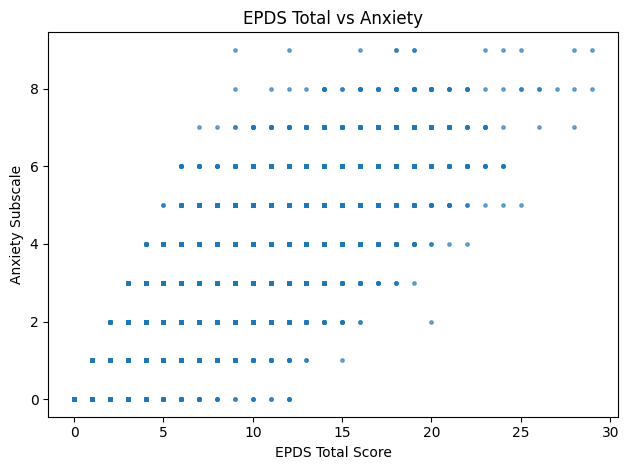

In [ ]:
# Simple relationship plot: EPDS Total vs Anxiety
plt.figure()
plt.scatter(df["Total Score"], df["Anxiety"], s=6, alpha=0.6)
plt.xlabel("EPDS Total Score")
plt.ylabel("Anxiety Subscale")
plt.title("EPDS Total vs Anxiety")
plt.tight_layout()
plt.show()